In [1]:
"""
The purpose of this notebook is to augment data to create more datapoints which would represent
fraudulent transactions.

The whole work of fraud detection is done in another notebook called 'fraud_detection.ipynb'
""";

In [2]:
import pandas as pd
import numpy as np
import os

In [3]:
from os import listdir
from os.path import isfile, join

loc = os.path.abspath("")
data_loc = f"{loc}/data"
print(data_loc)

C:\Users\ahmed\Desktop\IEEE-CIS-Fraud-Detection/data


In [4]:
%%time
train_identity   = pd.read_parquet(f"{data_loc}/train_identity.parquet.gzip")
train_transaction   = pd.read_parquet(f"{data_loc}/train_transaction.parquet.gzip")
test_identity   = pd.read_parquet(f"{data_loc}/test_identity.parquet.gzip")
test_transaction   = pd.read_parquet(f"{data_loc}/test_transaction.parquet.gzip")

Wall time: 1.72 s


Checking the number of total transactions in both the 'identity' and 'transaction' in train data:

In [5]:
print(train_transaction['TransactionID'].count())
print(train_identity['TransactionID'].count())

590540
144233


Merging the 'identity' and 'transaction' datasets together in one dataframe for both train and test data:

In [6]:
X_train = pd.merge(
    train_transaction, train_identity, how='left', on='TransactionID'
)

X_test = pd.merge(
    test_transaction, test_identity, how='left', on='TransactionID'  
)

In [7]:
print(f'Train shape: {X_train.shape}, Test shape: {X_test.shape}')

Train shape: (590540, 434), Test shape: (506691, 433)


In [8]:
X_train['isFraud'].value_counts()

0    569877
1     20663
Name: isFraud, dtype: int64

In [9]:
"""
Total fraudulent transactions  (20,663) in our dataset is very less compared to non-fraudulent
transactions (569,877). Therefore, new datapoints must be created to represent more fraudulent transactions.
""";

In [10]:
"""
EDA & Handling categorical data.
""";

In [11]:
pd.set_option('display.max_rows', None)
X_train.isnull().sum()

TransactionID          0
isFraud                0
TransactionDT          0
TransactionAmt         0
ProductCD              0
card1                  0
card2               8933
card3               1565
card4               1577
card5               4259
card6               1571
addr1              65706
addr2              65706
dist1             352271
dist2             552913
P_emaildomain      94456
R_emaildomain     453249
C1                     0
C2                     0
C3                     0
C4                     0
C5                     0
C6                     0
C7                     0
C8                     0
C9                     0
C10                    0
C11                    0
C12                    0
C13                    0
C14                    0
D1                  1269
D2                280797
D3                262878
D4                168922
D5                309841
D6                517353
D7                551623
D8                515614
D9                515614


In [12]:
pd.set_option('display.max_rows', 10)

In [13]:
print(X_train.shape)
print(X_test.shape)

(590540, 434)
(506691, 433)


There are plenty of columns with large numbers of missing data. Here we are removing columns with >= 50% missing values.

In [14]:
# remove columns with over 40% missing data points
threshold = int(X_train.shape[0] * 0.4)
cols_with_missing_values = [col for col in X_train.columns if X_train[col].isnull().sum() >= threshold]
cols_with_missing_values
X_train.drop(cols_with_missing_values, axis = 1, inplace = True)
X_train.shape

(590540, 202)

In [15]:
# columns with id in test are represented by "id-XX", whereas in the train set they are "id_XX"
# replace "-" with "_"
X_test.columns = X_test.columns.str.replace("-", "_")

In [16]:
X_test.drop(cols_with_missing_values, axis = 1, inplace = True)
X_test.shape

(506691, 201)

In [17]:
print(X_train.shape)
print(X_test.shape)

(590540, 202)
(506691, 201)


In [18]:
X_train.isnull().sum()

TransactionID      0
isFraud            0
TransactionDT      0
TransactionAmt     0
ProductCD          0
                  ..
V317              12
V318              12
V319              12
V320              12
V321              12
Length: 202, dtype: int64

In [19]:
# EDA
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Columns: 202 entries, TransactionID to V321
dtypes: float32(193), int32(4), object(5)
memory usage: 470.8+ MB


In [20]:
print(X_train.shape)
print(X_test.shape)

(590540, 202)
(506691, 201)


There are 5 object types that we need to convert to numerical data.

In [21]:
categorical_cols = [col for col in X_train.columns if X_train[col].dtype == "object"]
categorical_cols

['ProductCD', 'card4', 'card6', 'P_emaildomain', 'M6']

In [22]:
print(X_train['ProductCD'].unique())
print(X_test['ProductCD'].unique())

['W' 'H' 'C' 'S' 'R']
['W' 'C' 'S' 'H' 'R']


In [23]:
print(X_train['card4'].unique())
print(X_test['card4'].unique())

['discover' 'mastercard' 'visa' 'american express' None]
['visa' 'mastercard' 'american express' 'discover' None]


In [24]:
print(X_train['P_emaildomain'].unique())
print(X_test['P_emaildomain'].unique())

[None 'gmail.com' 'outlook.com' 'yahoo.com' 'mail.com' 'anonymous.com'
 'hotmail.com' 'verizon.net' 'aol.com' 'me.com' 'comcast.net'
 'optonline.net' 'cox.net' 'charter.net' 'rocketmail.com' 'prodigy.net.mx'
 'embarqmail.com' 'icloud.com' 'live.com.mx' 'gmail' 'live.com' 'att.net'
 'juno.com' 'ymail.com' 'sbcglobal.net' 'bellsouth.net' 'msn.com' 'q.com'
 'yahoo.com.mx' 'centurylink.net' 'servicios-ta.com' 'earthlink.net'
 'hotmail.es' 'cfl.rr.com' 'roadrunner.com' 'netzero.net' 'gmx.de'
 'suddenlink.net' 'frontiernet.net' 'windstream.net' 'frontier.com'
 'outlook.es' 'mac.com' 'netzero.com' 'aim.com' 'web.de' 'twc.com'
 'cableone.net' 'yahoo.fr' 'yahoo.de' 'yahoo.es' 'sc.rr.com' 'ptd.net'
 'live.fr' 'yahoo.co.uk' 'hotmail.fr' 'hotmail.de' 'hotmail.co.uk'
 'protonmail.com' 'yahoo.co.jp']
['gmail.com' 'aol.com' 'hotmail.com' None 'att.net' 'twc.com' 'yahoo.com'
 'verizon.net' 'anonymous.com' 'msn.com' 'q.com' 'outlook.com'
 'icloud.com' 'bellsouth.net' 'sbcglobal.net' 'web.de' 'live.com.

In [25]:
print(X_train['P_emaildomain'].unique())
print(X_test['P_emaildomain'].unique())

[None 'gmail.com' 'outlook.com' 'yahoo.com' 'mail.com' 'anonymous.com'
 'hotmail.com' 'verizon.net' 'aol.com' 'me.com' 'comcast.net'
 'optonline.net' 'cox.net' 'charter.net' 'rocketmail.com' 'prodigy.net.mx'
 'embarqmail.com' 'icloud.com' 'live.com.mx' 'gmail' 'live.com' 'att.net'
 'juno.com' 'ymail.com' 'sbcglobal.net' 'bellsouth.net' 'msn.com' 'q.com'
 'yahoo.com.mx' 'centurylink.net' 'servicios-ta.com' 'earthlink.net'
 'hotmail.es' 'cfl.rr.com' 'roadrunner.com' 'netzero.net' 'gmx.de'
 'suddenlink.net' 'frontiernet.net' 'windstream.net' 'frontier.com'
 'outlook.es' 'mac.com' 'netzero.com' 'aim.com' 'web.de' 'twc.com'
 'cableone.net' 'yahoo.fr' 'yahoo.de' 'yahoo.es' 'sc.rr.com' 'ptd.net'
 'live.fr' 'yahoo.co.uk' 'hotmail.fr' 'hotmail.de' 'hotmail.co.uk'
 'protonmail.com' 'yahoo.co.jp']
['gmail.com' 'aol.com' 'hotmail.com' None 'att.net' 'twc.com' 'yahoo.com'
 'verizon.net' 'anonymous.com' 'msn.com' 'q.com' 'outlook.com'
 'icloud.com' 'bellsouth.net' 'sbcglobal.net' 'web.de' 'live.com.

In [26]:
print(X_train['M6'].unique())
print(X_test['M6'].unique())

['T' 'F' None]
['F' 'T' None]


In [27]:
print(X_train['card6'].value_counts())

debit              439938
credit             148986
debit or credit        30
charge card            15
Name: card6, dtype: int64


In [28]:
# test set does not contain "debit or credit" data points for the "card6" column
# since there are only few of these, drop those rows from the train set
print(X_train.shape)
X_train.drop(X_train.loc[X_train['card6']=='debit or credit'].index, inplace=True)
print(X_train.shape)

(590540, 202)
(590510, 202)


Since there are many different datapoints for 'P_emaildomain' we will be LabelEncoding them and the rest of the categorical columns will be one-hot encoded.

In [29]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()

In [30]:
X_train['P_emaildomain'] = enc.fit_transform(X_train['P_emaildomain'])
X_train['P_emaildomain'];

X_test['P_emaildomain'] = enc.fit_transform(X_test['P_emaildomain'])
X_test['P_emaildomain'];

In [31]:
categorical_cols.remove('P_emaildomain')
categorical_cols

['ProductCD', 'card4', 'card6', 'M6']

In [32]:
X_train = pd.get_dummies(data=X_train, columns=categorical_cols)
X_test = pd.get_dummies(data=X_test, columns=categorical_cols)

In [33]:
print(X_train.shape)
print(X_test.shape)

(590510, 212)
(506691, 211)


In [34]:
# fill missing values with the mean
X_train.fillna(value=X_train.mean(), inplace=True)
X_test.fillna(value=X_test.mean(), inplace=True)

In [35]:
X_train.isnull().sum()

TransactionID        0
isFraud              0
TransactionDT        0
TransactionAmt       0
card1                0
                    ..
card6_charge card    0
card6_credit         0
card6_debit          0
M6_F                 0
M6_T                 0
Length: 212, dtype: int64

In [36]:
X_test.isnull().sum()

TransactionID        0
TransactionDT        0
TransactionAmt       0
card1                0
card2                0
                    ..
card6_charge card    0
card6_credit         0
card6_debit          0
M6_F                 0
M6_T                 0
Length: 211, dtype: int64

In [37]:
print(X_train.shape)
X_train = X_train.drop(X_train[X_train['isFraud'] == 0].sample(frac=.92).index)
print(X_train.shape)

(590510, 212)
(66251, 212)


In [38]:
# END OF PREPROCESSING

In [39]:
X = X_train.drop('isFraud', axis=1).copy()

In [40]:
y = X_train['isFraud'].copy()

In [41]:
# train test-split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.fit_transform(X_test)
x_train, x_val, y_train, y_val = train_test_split(X_train_scaled, y, test_size=0.25, random_state=42)

In [42]:
from collections import Counter
Counter(y_val)

Counter({0: 11369, 1: 5194})

In [43]:
# from collections import Counter
# from imblearn.under_sampling import NearMiss
# ns=NearMiss(version=1, n_neighbors=3)
# x_train_aug, y_train_aug = ns.fit_resample(x_train,y_train)
# print("The number of classes before fit {}".format(Counter(y_train)))
# print("The number of classes after fit {}".format(Counter(y_train_aug)))

In [44]:
from collections import Counter
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
x_train_aug, y_train_aug = oversample.fit_resample(x_train, y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_aug)))

The number of classes before fit Counter({0: 34219, 1: 15469})
The number of classes after fit Counter({0: 34219, 1: 34219})


RandomForest
____________________________
Accuracy: 0.8819658274467186
Precision: 0.8453828108338665
Recall: 0.7631882941855987
F1 Score: 0.8021855711828393
____________________________
Confusion Matrix: 
 [[10644   725]
 [ 1230  3964]]
____________________________
False Positive Rate: 0.06376990060691357
False Negative Rate: 0.23681170581440125
____________________________
AUC: 0.926721692482442


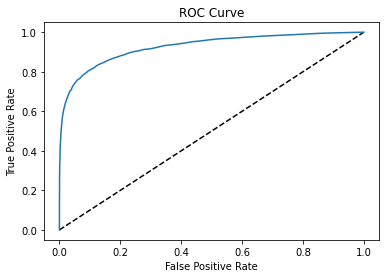

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import recall_score
from matplotlib import pyplot
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

clf_rfc=RandomForestClassifier(n_estimators=93, random_state=143)
clf_rfc.fit(x_train_aug,y_train_aug)
y_pred=clf_rfc.predict(x_val)

print("RandomForest")
print("____________________________")
print("Accuracy:",metrics.accuracy_score(y_val, y_pred))
print("Precision:",metrics.precision_score(y_val, y_pred))
print("Recall:",metrics.recall_score(y_val, y_pred))
print("F1 Score:",metrics.f1_score(y_val, y_pred))
print("____________________________")
print("Confusion Matrix: \n", metrics.confusion_matrix(y_val, y_pred))

tpr = recall_score(y_val, y_pred) 
tnr = recall_score(y_val, y_pred, pos_label = 0) 
fpr = 1 - tnr
fnr = 1 - tpr
print("____________________________")
print("False Positive Rate:",fpr)
print("False Negative Rate:",fnr)

y_pred_prob = clf_rfc.predict_proba(x_val)[:,1]

# Compute and print AUC score
print("____________________________")
print("AUC: {}".format(roc_auc_score(y_val, y_pred_prob)))

# Compute cross-validated AUC scores: cv_auc
#cv_auc = cross_val_score(logreg, X, y, cv=5, scoring='roc_auc')

# Print list of AUC scores
#print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc))

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)

# Plot ROC curve
pyplot.plot([0, 1], [0, 1], 'k--')
pyplot.plot(fpr, tpr)
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('ROC Curve')
pyplot.show()

In [46]:
y_pred_prob = clf_rfc.predict_proba(X_test_scaled)[:,1]

In [47]:
sample_dataset = pd.read_csv('data/sample_submission.csv')
sample_dataset = sample_dataset.drop('isFraud', axis=1)
sample_dataset['isFraud'] = y_pred_prob.copy()
sample_dataset

,TransactionID,isFraud
0,3663549,0.623656
1,3663550,0.537634
2,3663551,0.591398
3,3663552,0.666667
4,3663553,0.537634
...,...,...
506686,4170235,0.774194
506687,4170236,0.741935
506688,4170237,0.741935
506689,4170238,0.784946


In [48]:
sample_dataset.to_csv('first submission.csv', index=False) 

In [49]:
# from sklearn.decomposition import PCA
# pca = PCA().fit(x_train)

In [50]:
# x_train.shape

In [51]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# plt.rcParams["figure.figsize"] = (60,6)

# fig, ax = plt.subplots()
# xi = np.arange(1, 212, step=1)
# yi = np.cumsum(pca.explained_variance_ratio_)

# plt.ylim(0.0,1.1)
# plt.plot(xi, yi, marker='o', linestyle='--', color='b')

# plt.xlabel('Number of Components')
# plt.xticks(np.arange(0, 413, step=1)) #change from 0-based array index to 1-based human-readable label
# plt.xticks(rotation=90)
# plt.ylabel('Cumulative variance (%)')
# plt.title('The number of components needed to explain variance for dataset 1')

# plt.axhline(y=0.99, color='r', linestyle='-')
# plt.text(0.7, 0.75, '99% cut-off threshold', color = 'red', fontsize=16)

# ax.grid(axis='x')
# plt.show()

In [52]:
# model_pca = PCA(n_components=126)

# pca_x_train = model_pca.fit_transform(x_train)
# pca_x_val  = model_pca.transform(x_val)
# pca_X_test  = model_pca.transform(X_test)

In [53]:
# print(x_train.shape)
# print(x_val.shape)
# print(X_test.shape)

In [54]:
# print(pca_x_train.shape)
# print(pca_x_val.shape)
# print(pca_X_test.shape)

MLP With PCA

In [55]:
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Activation, Dense
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.metrics import categorical_crossentropy

In [56]:
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# print("Num GPUs Available: ", len(physical_devices))
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [57]:
# model = Sequential([
#     Dense(units=16, input_shape=(211,), activation='relu'),
#     Dense(units=32, activation='relu'),
#     Dense(units=16, activation='relu'),
#     Dense(units=8, activation='relu'),
#     Dense(units=2, activation='softmax')
# ])

In [58]:
# model.summary()

In [59]:
# model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [60]:
# model.fit(x=x_train, y=y_train, batch_size=10, epochs=15, verbose=2, validation_data=(x_val,y_val))

In [61]:
# predictions = model.predict(
#       x=X_test
#     , batch_size=10
#     , verbose=0
# )  

In [62]:
# for i in predictions:
#     print(i)

RFC With PCA

In [63]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn import metrics
# from sklearn.metrics import recall_score
# from matplotlib import pyplot
# from sklearn.metrics import recall_score
# from sklearn.metrics import roc_curve
# from sklearn.metrics import roc_auc_score

# clf_rfc=RandomForestClassifier(n_estimators=93, random_state=143)
# clf_rfc.fit(pca_x_train,y_train)
# y_pred=clf_rfc.predict(pca_x_val)

# print("RandomForest")
# print("____________________________")
# print("Accuracy:",metrics.accuracy_score(y_val, y_pred))
# print("Precision:",metrics.precision_score(y_val, y_pred))
# print("Recall:",metrics.recall_score(y_val, y_pred))
# print("F1 Score:",metrics.f1_score(y_val, y_pred))
# print("____________________________")
# print("Confusion Matrix: \n", metrics.confusion_matrix(y_val, y_pred))

# tpr = recall_score(y_val, y_pred) 
# tnr = recall_score(y_val, y_pred, pos_label = 0) 
# fpr = 1 - tnr
# fnr = 1 - tpr
# print("____________________________")
# print("False Positive Rate:",fpr)
# print("False Negative Rate:",fnr)

# y_pred_prob = clf_rfc.predict_proba(pca_x_val)[:,1]

# # Compute and print AUC score
# print("____________________________")
# print("AUC: {}".format(roc_auc_score(y_val, y_pred_prob)))

# # Compute cross-validated AUC scores: cv_auc
# #cv_auc = cross_val_score(logreg, X, y, cv=5, scoring='roc_auc')

# # Print list of AUC scores
# #print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc))

# # Generate ROC curve values: fpr, tpr, thresholds
# fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)

# # Plot ROC curve
# pyplot.plot([0, 1], [0, 1], 'k--')
# pyplot.plot(fpr, tpr)
# pyplot.xlabel('False Positive Rate')
# pyplot.ylabel('True Positive Rate')
# pyplot.title('ROC Curve')
# pyplot.show()

In [64]:
# y_pred_prob = clf_rfc.predict_proba(pca_X_test)[:,1]

In [65]:
# sample_dataset = pd.read_csv('data/sample_submission.csv')
# sample_dataset = sample_dataset.drop('isFraud', axis=1)
# sample_dataset['isFraud'] = y_pred_prob.copy()
# sample_dataset

In [66]:
# sample_dataset.to_csv('first submission.csv', index=False) 

RFC Without PCA

In [67]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn import metrics
# from sklearn.metrics import recall_score
# from matplotlib import pyplot
# from sklearn.metrics import recall_score
# from sklearn.metrics import roc_curve
# from sklearn.metrics import roc_auc_score

# clf_rfc=RandomForestClassifier(n_estimators=93, random_state=143)
# clf_rfc.fit(x_train,y_train)
# y_pred=clf_rfc.predict(x_val)

# print("RandomForest")
# print("____________________________")
# print("Accuracy:",metrics.accuracy_score(y_val, y_pred))
# print("Precision:",metrics.precision_score(y_val, y_pred))
# print("Recall:",metrics.recall_score(y_val, y_pred))
# print("F1 Score:",metrics.f1_score(y_val, y_pred))
# print("____________________________")
# print("Confusion Matrix: \n", metrics.confusion_matrix(y_val, y_pred))

# tpr = recall_score(y_val, y_pred) 
# tnr = recall_score(y_val, y_pred, pos_label = 0) 
# fpr = 1 - tnr
# fnr = 1 - tpr
# print("____________________________")
# print("False Positive Rate:",fpr)
# print("False Negative Rate:",fnr)

# y_pred_prob = clf_rfc.predict_proba(x_val)[:,1]

# # Compute and print AUC score
# print("____________________________")
# print("AUC: {}".format(roc_auc_score(y_val, y_pred_prob)))

# # Compute cross-validated AUC scores: cv_auc
# #cv_auc = cross_val_score(logreg, X, y, cv=5, scoring='roc_auc')

# # Print list of AUC scores
# #print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc))

# # Generate ROC curve values: fpr, tpr, thresholds
# fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)

# # Plot ROC curve
# pyplot.plot([0, 1], [0, 1], 'k--')
# pyplot.plot(fpr, tpr)
# pyplot.xlabel('False Positive Rate')
# pyplot.ylabel('True Positive Rate')
# pyplot.title('ROC Curve')
# pyplot.show()

In [68]:
# y_pred_prob = clf_rfc.predict_proba(X_test)[:,1]

In [69]:
# sample_dataset = pd.read_csv('data/sample_submission.csv')
# sample_dataset = sample_dataset.drop('isFraud', axis=1)
# sample_dataset['isFraud'] = y_pred_prob.copy()
# sample_dataset.tail(100)

In [70]:
# sample_dataset.to_csv('first submission.csv', index=False) 